In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf
from fxpmath import Fxp
np.random.seed(0)
tf.random.set_seed(0)
print(tf.config.list_physical_devices('GPU'))

import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

import hls4ml
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute
from hls4ml.model.types import FixedPrecisionType, RoundingMode, SaturationMode
from hls4ml.model.attributes import Attribute

# Source the Vivado path
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2025-01-14 15:14:10.338254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 15:14:10.442089: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 15:14:10.445253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-14 15:14:10.445270: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

[]


2025-01-14 15:14:12.629625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-14 15:14:12.629783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-14 15:14:12.629842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-01-14 15:14:12.629888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-01-14 15:14:12.629929: W tensorf

/home/aelabd/RHEED/hls4ml/hls4ml/converters/__init__.py:29: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Globals

In [2]:
SAMPLE_SMALL = True
SAMPLE_LARGE = False
DATA_DIR = 'data' 
RHEED_DATA_FILE = DATA_DIR + '/RHEED_4848_test6.h5'
LOAD_LABELS = True # (Takes <1 min to load, ~40 mins to generate)
PRINT_SAMPLE_GAUSSIAN = False
PRINT_SAMPLE_LOSS = True
SYSTEMATIC_TESTBENCH = False

TRAIN_MODEL = False
SAVE_MODEL = False
LOAD_MODEL = True

IMAGE_SIZE = (100, 160)
NUM_BLOBS = 1
CROP_BOX_ROWS = 48
CROP_BOX_COLS = 48

BATCH_SIZE = 1000
NUM_EPOCHS = 1
LEARNING_RATE = 0.0001

FP_TOTAL = 16
FP_INT = 2
REUSE_FACTOR = 32

# Load data

[Normalized Images Shape]: (2000, 48, 48)
[Normalized Image #684]:


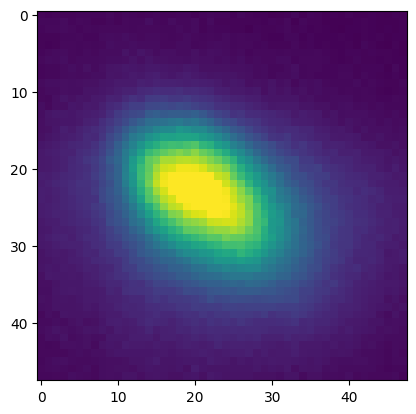

In [3]:
output_scaler = StandardScaler()
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)

if SAMPLE_SMALL:
    normalized_images = normalized_images[:2000, :, :]
elif SAMPLE_LARGE:
    normalized_images = normalized_images[:20000, :, :]
else: pass

print(f'[Normalized Images Shape]: {normalized_images.shape}')

# Validate Data Array:
validate_data_array = True
if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

In [4]:
# Functions for estimating labels

# generate 2d Gaussian from its parameters
# x, y = x-coord, y-coord
# A = amplitude
# x0, y0 = mean-x, mean-y
# sigma_x, sigma_y = std.-dev.-x, std.-dev.-y
def gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y):
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Initial guess for each parameter
# data = normalized image
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Compute residuals
# params = A, x0, y0, sigma_x, sigma_y
# x, y  = x-coord, y-coord
# data = normalized image
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

# Convert parameters from A, x0, y0, sigma_x, sigma_y --> mean_x, mean_y, cov_x, cov_y, theta
# params = A, x0, y0, sigma_x, sigma_y
def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

@delayed
def fit_gaussian_2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x


In [5]:
# Import From File
if LOAD_LABELS:
    file_path = 'data/Results.npy'
    estimated_labels = np.load(file_path)
    # estimated_labels = np.random.rand(normalized_images.shape[0], 5)

# Generate
else:
    estimated_labels = []
    with Client() as client:
        guesses = [add_guess(image) for image in normalized_images]
        fits = [fit_gaussian_2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
        estimated_labels = [convert_parameters(params) for params in compute(*fits)]
    estimated_labels = np.array(estimated_labels).astype(np.float32)

if SAMPLE_SMALL:
    estimated_labels = estimated_labels[:2000]
elif SAMPLE_LARGE:
    estimated_labels = estimated_labels[:20000]
else: pass

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(normalized_images)
    dataset = dataset.shuffle(normalized_images.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)

output_scaler.fit(estimated_labels)

[Estimated Labels Shape]: (2000, 5)


2025-01-14 15:14:18.354827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


StandardScaler()

In [6]:
# Gaussian Function: 
# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=1)

if PRINT_SAMPLE_GAUSSIAN:
    image_shape = (CROP_BOX_ROWS, CROP_BOX_COLS)
    batch = tf.convert_to_tensor([
        [21.8558168, 24.50041009, 10.31268177, 9.1700225, 0.72681534]
        , [21.76068143, 24.37956637, 10.30043488, 9.15426013, 0.72655111]
        , [21.72363929, 24.31050759, 10.33800891, 9.18570812, 0.72644599]
        , [21.72777699, 24.29306623, 10.30178808, 9.14728058, 0.72610718]
        , [21.79849472, 24.34649405, 10.32683150, 9.16259293, 0.72573213]
    ])
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()


# Custom Loss Function (TENSORFLOW):
def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if PRINT_SAMPLE_LOSS:
  I = tf.random.normal((5, 1, CROP_BOX_ROWS, CROP_BOX_COLS))
  J = tf.random.normal((5, 1, CROP_BOX_ROWS, CROP_BOX_COLS))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

[Custom Weighted MSE Loss]: 4.103805


 # 1. Train and convert just the Gaussian predictor

In [7]:
model_g = tf.keras.Sequential(
    [   
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(CROP_BOX_ROWS, CROP_BOX_COLS, 1)) # (batch_size, height, width, channels)
        # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

        , tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')
        # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(units=98, activation='relu')
        , tf.keras.layers.Dense(units=52, activation='relu')
        , tf.keras.layers.Dense(units=5)
    ]
)
model_g_checkpoint_path = "GaussianModel.keras"
model_g.compile(optimizer='adam', loss=custom_weighted_mse_loss)
print(f"n_params = {model_g.count_params()}")
losses_g = []
# Training Loop
if TRAIN_MODEL:
    best_loss = float('inf')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    n = 1

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model_g(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (CROP_BOX_ROWS, CROP_BOX_COLS))
                loss = custom_weighted_mse_loss(image_batch, final, n)
                losses_g.append(loss)
            grads = tape.gradient(loss, model_g.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_g.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {average_loss}")

    if SAVE_MODEL:
        model_g.save(model_g_checkpoint_path)
        print(f"\nSaved model to {model_g_checkpoint_path}")

    plt.figure()
    plt.plot(losses_g)
    plt.title('Loss: Gaussian Model')
    plt.show()
    plt.close()

if LOAD_MODEL:
    model_g.load_weights(model_g_checkpoint_path)
    print(f"Loaded model from {model_g_checkpoint_path}\n")

model_g.summary()

n_params = 22195
Loaded model from GaussianModel.keras

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 re_lu (ReLU)                (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          2416      
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 16)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         


In [8]:
# Generate the configuration from the Keras model
config_g = hls4ml.utils.config_from_keras_model(model_g)
config_g['Model']['Precision']['default'] = f"ap_fixed<{FP_TOTAL},{FP_INT}>"
config_g['Model']['ReuseFactor'] = REUSE_FACTOR
config_g['Model']['Strategy'] = 'Resource'

# Attempt conversion on simplified model
hls_model_g = hls4ml.converters.convert_from_keras_model(
    model_g, hls_config=config_g, output_dir=f"model_g/{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF{REUSE_FACTOR}_ap_fixed_{FP_TOTAL}_{FP_INT}", part='xcu250-figd2104-2L-e', io_type="io_stream"
)

print("\n\nhls_model_g.config.config:")
for k, v in hls_model_g.config.config.items():
    if isinstance(v, dict):
        print(f"\n{k}: ")
        for kk, vv in v.items():
            print(f"  {kk}: {vv}")
        print("")
    else: print(f"{k}, {v}")
print(hls_model_g.config.config)

hls_model_g.compile()

Interpreting Sequential
Topology:
Layer name: conv2d_input, layer type: InputLayer, input shapes: [[None, 48, 48, 1]], output shape: [None, 48, 48, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: re_lu, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: re_lu_1, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 7, 7, 16]], output shape: [None, 3, 3, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 3, 3, 16]], output shape: [None, 144]
Layer name: dense, layer type: Dense, input shapes: [[None, 144]], outpu

model_g: Compare keras vs hls4ml

In [9]:
kpred_model_g = model_g(normalized_images[:10]).numpy()
hpred_model_g = hls_model_g.predict(np.ascontiguousarray(normalized_images[:10]))

print("keras <--> hls diff, no padding/cropping:")
print(np.abs(kpred_model_g - hpred_model_g))

keras <--> hls diff, no padding/cropping:
[[4.2634010e-03 4.3348372e-03 2.6682973e-02 4.0417910e+00 1.2553573e-02]
 [3.7560463e-03 4.6606958e-03 2.6427746e-02 4.0419636e+00 1.2823433e-02]
 [4.1230917e-03 4.5671165e-03 2.6482224e-02 4.0419579e+00 1.2621731e-02]
 [4.3402761e-03 4.4067800e-03 2.6881695e-02 4.0417786e+00 1.2923330e-02]
 [4.0439665e-03 4.6060085e-03 2.6509285e-02 4.0416613e+00 1.2614518e-02]
 [3.9139092e-03 3.8706362e-03 2.6736975e-02 4.0420561e+00 1.2564987e-02]
 [4.1650534e-03 4.3178499e-03 2.6392221e-02 4.0420198e+00 1.2497336e-02]
 [4.1407347e-03 4.4792295e-03 2.6345730e-02 4.0419731e+00 1.2844920e-02]
 [3.7644506e-03 3.9793849e-03 2.6946545e-02 4.0420022e+00 1.2805909e-02]
 [4.3294132e-03 4.2350590e-03 2.6540756e-02 4.0419993e+00 1.2692362e-02]]


In [10]:
kpred_model_g

array([[ 0.04259348, -0.27142468, -1.1398422 ,  2.2010925 ,  0.39567125],
       [ 0.04281855, -0.27040777, -1.1358027 ,  2.1918662 ,  0.39545283],
       [ 0.04507768, -0.27098557, -1.1348196 ,  2.1855125 ,  0.39360318],
       [ 0.04456244, -0.26923832, -1.1429095 ,  2.1960144 ,  0.3944541 ],
       [ 0.04505959, -0.2714517 , -1.1413774 ,  2.1991932 ,  0.39719704],
       [ 0.04218295, -0.27352396, -1.1455114 ,  2.2097805 ,  0.39842924],
       [ 0.04225099, -0.27445945, -1.1419318 ,  2.211942  ,  0.3978733 ],
       [ 0.04344738, -0.27346116, -1.1442046 ,  2.2083552 ,  0.39608467],
       [ 0.04355937, -0.27070302, -1.138946  ,  2.1947122 ,  0.39397046],
       [ 0.04388019, -0.26741865, -1.1392727 ,  2.1894603 ,  0.3955659 ]],
      dtype=float32)

In [11]:
hpred_model_g

array([[ 0.03833008, -0.26708984, -1.1131592 , -1.8406982 ,  0.38311768],
       [ 0.0390625 , -0.26574707, -1.109375  , -1.8500977 ,  0.3826294 ],
       [ 0.04095459, -0.26641846, -1.1083374 , -1.8564453 ,  0.38098145],
       [ 0.04022217, -0.26483154, -1.1160278 , -1.8457642 ,  0.38153076],
       [ 0.04101562, -0.2668457 , -1.1148682 , -1.8424683 ,  0.38458252],
       [ 0.03826904, -0.26965332, -1.1187744 , -1.8322754 ,  0.38586426],
       [ 0.03808594, -0.2701416 , -1.1155396 , -1.8300781 ,  0.38537598],
       [ 0.03930664, -0.26898193, -1.1178589 , -1.8336182 ,  0.38323975],
       [ 0.03979492, -0.26672363, -1.1119995 , -1.84729   ,  0.38116455],
       [ 0.03955078, -0.2631836 , -1.1127319 , -1.8525391 ,  0.38287354]],
      dtype=float32)

In [12]:
# TRAIN_Q_MODEL = True
# SAVE_Q_MODEL = True
# LOAD_Q_MODEL = False
# qmodel_g = tf.keras.Sequential(
#     [   
#         qkeras.QConv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(CROP_BOX_ROWS, CROP_BOX_COLS, 1)) # (batch_size, height, width, channels)
#         # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
#         , qkeras.quantized_relu()
#         , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

#         , qkeras.QConv2D(filters=16, kernel_size=5, strides=1, padding='valid')
#         # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
#         , qkeras.quantized_relu()
#         , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

#         , tf.keras.layers.Flatten()
#         , qkeras.QDense(units=98, activation='relu')
#         , qkeras.QDense(units=52, activation='relu')
#         , qkeras.QDense(units=5)
#     ]
# )
# qmodel_g_checkpoint_path = "QGaussianModel.keras"
# qmodel_g.compile(optimizer='adam', loss=custom_weighted_mse_loss)
# print(f"n_params = {model_g.count_params()}")
# losses_g = []
# # Training Loop
# if TRAIN_Q_MODEL:
#     best_loss = float('inf')
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#     n = 1

#     for epoch in range(NUM_EPOCHS):
#         running_loss = 0.0

#         if epoch % 10 == 0:
#             n += 0.1

#         for image_batch in tqdm(dataset): 
#             image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
#             with tf.GradientTape() as tape:
#                 embedding = qmodel_g(image_batch)
#                 unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
#                 final = generate_guassian(unscaled_param, (CROP_BOX_ROWS, CROP_BOX_COLS))
#                 loss = custom_weighted_mse_loss(image_batch, final, n)
#                 losses_g.append(loss)
#             grads = tape.gradient(loss, qmodel_g.trainable_variables)
#             optimizer.apply_gradients(zip(grads, qmodel_g.trainable_variables))

#             running_loss += loss.numpy()
#         average_loss = running_loss / len(dataset)
#         print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {average_loss}")

#     if SAVE_Q_MODEL:
#         qmodel_g.save(qmodel_g_checkpoint_path)
#         print(f"\nSaved model to {qmodel_g_checkpoint_path}")

#     plt.figure()
#     plt.plot(losses_g)
#     plt.title('Loss: Gaussian Model')
#     plt.show()
#     plt.close()

# if LOAD_Q_MODEL:
#     qmodel_g.load_weights(qmodel_g_checkpoint_path)
#     print(f"Loaded model from {qmodel_g_checkpoint_path}\n")

# qmodel_g.summary()

# # Post Training Quantization
# Q_FP_TOTAL = FP_TOTAL+13
# Q_FP_INT = FP_INT+7
# SAVE_QMODEL = False
# q_dict = {
#     "QConv2D": {
#         "kernel_quantizer": f"quantized_bits({Q_FP_TOTAL},{Q_FP_INT},1)",
#         "bias_quantizer": f"quantized_bits({Q_FP_TOTAL},{Q_FP_INT},1)"
#     },
#     "QDense": {
#         "kernel_quantizer": f"quantized_bits({Q_FP_TOTAL},{Q_FP_INT},1)",
#         "bias_quantizer": f"quantized_bits({Q_FP_TOTAL},{Q_FP_INT},1)"
#     },
#     "QBatchNormalization": f"quantized_bits({Q_FP_TOTAL},{Q_FP_INT},1)",

#     "QActivation": F"quantized_relu({Q_FP_TOTAL},{Q_FP_INT},1)"
# }

# qmodel_g = model_quantize(model_g, q_dict, Q_FP_TOTAL, transfer_weights=True)
# print_qstats(qmodel_g)

# if SAVE_QMODEL:
#     qmodel_g.save(f"Quantized_Gaussian_Model({Q_FP_TOTAL},{Q_FP_INT}).keras")

# qpred_model_g = qmodel_g(normalized_images[:10]).numpy()
# print("QKeras <--> Keras diff, no padding/cropping:")
# print(np.abs(qpred_model_g - kpred_model_g))

In [13]:
# hls_model_g.build(csim=False, synth=True, vsynth=True)

Save no-crop testbench data

In [14]:
from fxpmath import Fxp

############### Input ########################
tb_image_g = normalized_images[0]
tb_kpred_model_g = kpred_model_g[0]
tb_hpred_model_g = hpred_model_g[0]

# float
np.save(os.path.join("testbench_no_crop/tb_data", f"tb_image_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_float32.npy"), tb_image_g)

# ap_fixed
tb_image_g_ap_fixed = Fxp(tb_image_g, signed=True, n_word=FP_TOTAL, n_frac=FP_TOTAL-FP_INT).bin()
with open(os.path.join("testbench_no_crop/tb_data", f"tb_image_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'w') as f:
    for row in tb_image_g_ap_fixed:
        for val in row:
            f.write(str(val))
            f.write('\n')


############### Output #######################

# float
np.save(os.path.join("testbench_no_crop/tb_data", f"keras_pred_{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy"), tb_kpred_model_g)
np.save(os.path.join("testbench_no_crop/tb_data", f"hls_model_pred_{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy"), tb_hpred_model_g)

# ap_fixed
tb_hpred_model_g_ap_fixed = Fxp(tb_hpred_model_g, signed=True, n_word=FP_TOTAL, n_frac=FP_TOTAL-FP_INT).bin()
with open(os.path.join("testbench_no_crop/tb_data", f"hls_model_pred_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF{REUSE_FACTOR}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'w') as f:
    for g_param_idx in range(5):
        for g_param_bit in range(FP_TOTAL):
            f.write(str(tb_hpred_model_g_ap_fixed[g_param_idx][g_param_bit]))
        f.write('\n')


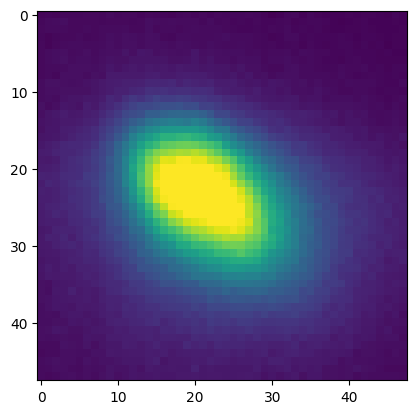

In [15]:
plt.imshow(tb_image_g)

# Train and convert the Gaussian predictor but with a CropLayer on top

In [16]:
from pathlib import Path
from tensorflow.keras import layers
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import Attribute

### Data

In [17]:
import copy
CROP_COORDS_HARD = np.array([0.38787913, 0.37316015, 0.86787915, 0.67316014], dtype=np.float32)

y1 = int(CROP_COORDS_HARD[0]*IMAGE_SIZE[0])
x1 = int(CROP_COORDS_HARD[1]*IMAGE_SIZE[1])
y2 = int(CROP_COORDS_HARD[2]*IMAGE_SIZE[0])
x2 = int(CROP_COORDS_HARD[3]*IMAGE_SIZE[1])

normalized_images = normalized_images[:int(1e5)]
padded_normalized_images = np.random.rand(normalized_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1]).astype(np.float32)
padded_normalized_images[:, y1:y2, x1:x2] = copy.deepcopy(normalized_images)

if not (SAMPLE_SMALL|SAMPLE_LARGE):
    del normalized_images # memory issues

with tf.device('CPU'):
    padded_dataset = tf.data.Dataset.from_tensor_slices(padded_normalized_images[:int(5e5)])
    padded_dataset = padded_dataset.shuffle(padded_normalized_images.shape[0], reshuffle_each_iteration=True)
    padded_dataset = padded_dataset.batch(BATCH_SIZE)


### Keras Model

In [18]:
class CropLayer(layers.Layer):
    def __init__(self, image_shape, crop_shape, num_boxes, **kwargs):
        super(CropLayer, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.crop_shape = crop_shape
        self.num_boxes = num_boxes

    def call(self, inputs):
        image = inputs
        batch_size = tf.shape(image)[0]

        # TODO: migrate to tf.image.crop_and_resize
        crop_bb = np.array([CROP_COORDS_HARD[0]*self.image_shape[0], CROP_COORDS_HARD[1]*self.image_shape[1], CROP_COORDS_HARD[2]*self.image_shape[0], CROP_COORDS_HARD[3]*self.image_shape[1]]) #TODO: softcode
        crop_bb = tf.convert_to_tensor(crop_bb, dtype=np.int32)
        offset_height = crop_bb[0]
        offset_width = crop_bb[1]
        target_height = crop_bb[2] - crop_bb[0]
        target_width = crop_bb[3] - crop_bb[1]

        cropped_images = tf.image.crop_to_bounding_box(image=image, 
                                                      offset_height=offset_height, offset_width=offset_width,
                                                      target_height=target_height, target_width=target_width)
        
        return cropped_images
    
    def get_config(self):
        # Breaks serialization and parsing in hls4ml if not defined
        return super().get_config()

In [19]:
model_cpg = tf.keras.Sequential(
    [   
        CropLayer(image_shape = IMAGE_SIZE, crop_shape = (CROP_BOX_ROWS, CROP_BOX_COLS), num_boxes = 1, batch_input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', input_shape=(CROP_BOX_ROWS, CROP_BOX_COLS, 1)) # (batch_size, height, width, channels)
        # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=4, strides=4)

        , tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid')
        # , tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05) # TODO: Figure out why hls4ml won't convert batchnorm
        , tf.keras.layers.ReLU()
        , tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(units=98, activation='relu')
        , tf.keras.layers.Dense(units=52, activation='relu')
        , tf.keras.layers.Dense(units=5)
    ]
)
model_cpg.compile(optimizer='adam', loss=custom_weighted_mse_loss)
print(f"n_params: {model_cpg.count_params()}")

model_cpg_checkpoint_path = "GaussianModel_wcrop.keras"

# Training Loop
losses_cpg = []
if TRAIN_MODEL:
    best_loss = float('inf')
    num_epochs = 1
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(padded_dataset): 
            image_batch = tf.expand_dims(image_batch, axis=3) # (batch_size, height, width, channels)
            with tf.GradientTape() as tape:
                embedding = model_cpg(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (CROP_BOX_ROWS, CROP_BOX_COLS))
                unpadded_image_batch = image_batch[:, y1:y2, x1:x2, :]
                loss = custom_weighted_mse_loss(unpadded_image_batch, final, n)
                losses_cpg.append(loss)
            grads = tape.gradient(loss, model_cpg.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_cpg.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

        plt.figure()
        plt.plot(losses_cpg)
        plt.title('Loss: Gaussian Model w/ Crop Layer')
        plt.show()
        plt.close()

if SAVE_MODEL:
    model_cpg.save(model_cpg_checkpoint_path)
    print(f"\nSaved model to {model_cpg_checkpoint_path}")

if LOAD_MODEL:
    model_cpg.load_weights(model_cpg_checkpoint_path)
    print(f"Loaded model from {model_cpg_checkpoint_path}\n")

model_cpg.summary()



n_params: 22195
Loaded model from GaussianModel_wcrop.keras

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 crop_layer (CropLayer)      (None, 48, 48, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 re_lu_2 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          2416      
                                                                 
 re_lu_3 (ReLU)              (None, 7, 7, 16)          0   

### hls4ml model

In [20]:
def parse_crop_layer(keras_layer, input_names, input_shapes, data_reader):
    assert 'CropLayer' in keras_layer['class_name']
    
    crop_shape = None
    for l in data_reader.model.layers:
        try:
            # if l.name == keras_layer['name']:
            if isinstance(l, CropLayer): # TODO: Messy
                crop_shape = l.crop_shape
        except KeyError:
            pass
    if crop_shape is None:
        raise AttributeError(f"Could not find crop_shape attribute for layer {keras_layer['name']}")

    layer = parse_default_keras_layer(keras_layer, input_names)
    img_shape = input_shapes[0]

    num_boxes = NUM_BLOBS # TODO: soft-code
    num_channels = img_shape[-1]
    output_shape = [None, num_boxes, crop_shape[0], crop_shape[1], num_channels]

    layer["num_boxes"] = num_boxes
    layer["num_channels"] = num_channels
    layer["img_shape"] = img_shape
    max_idx = np.multiply(np.multiply(img_shape[1], img_shape[2]), img_shape[3])
    layer["idx_t"] = f"ap_uint<{int(np.ceil(np.log2(max_idx)) + 1)}>"

    return layer, output_shape

class HCropLayer(hls4ml.model.layers.Layer):
    "hls4ml implementation of the CropLayer"
    _expected_attributes = [Attribute('crop_rows'), Attribute('crop_cols')]

    def initialize(self):
        inp_0 = self.model.get_layer_output_variable(self.inputs[0]) # Image

        crop_shape = None
        for l in self.model.config.config['KerasModel'].layers:
            if l.name == self.get_attr('name'):
                crop_shape = l.crop_shape
        if crop_shape is None:
            raise AttributeError(f"Could not find crop_shape attribute for layer {self.get_attr('name')}")
        else:
            self.set_attr('crop_rows', crop_shape[0])
            self.set_attr('crop_cols', crop_shape[1])

        num_channels = inp_0.shape[-1]
        num_channels_name = inp_0.dim_names[-1]
        num_boxes = NUM_BLOBS # TODO: soft-code
        num_boxes_name = "NUM_BOXES"

        crop_rows = self.get_attr('crop_rows')
        crop_cols = self.get_attr('crop_cols')

        shape = [num_boxes, crop_rows, crop_cols, num_channels]
        dim_names = [num_boxes_name, f"CROP_ROWS_{self.index}", f"CROP_COLS_{self.index}", num_channels_name]
        self.add_output_variable(shape, dim_names)

hls4ml.converters.register_keras_layer_handler('CropLayer', parse_crop_layer)
hls4ml.model.layers.register_layer('CropLayer', HCropLayer)

# Templates
crop_config_template = """struct config{index} : nnet::crop_config {{
    static const unsigned in_height = {in_height};
    static const unsigned in_width = {in_width};
    static const unsigned n_chan = {n_chan};
    static const unsigned n_crop_boxes = {n_crop_boxes};
    static const unsigned crop_rows = {crop_rows};
    static const unsigned crop_cols = {crop_cols};
\\
}};\n"""

crop_function_template = "nnet::crop<{input1_t}, {index_t}, {output_t}, {config}>({input1}, {output});"

crop_include_list = ["nnet_utils/nnet_crop.h"]

class HCropLayerConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HCropLayer)
        self.template = crop_config_template

    def format(self, node):
        params = self._default_config_params(node)

        image_input = node.get_input_variable(node.inputs[0])
        params['in_height'] = image_input.shape[0]
        params['in_width'] = image_input.shape[1]
        params['n_chan'] = image_input.shape[2]

        # crop_coords_input = node.get_input_variable(node.inputs[1])
        params['n_crop_boxes'] = NUM_BLOBS # TODO: soft-code
        params['crop_rows'] = CROP_BOX_ROWS # TODO: soft-code
        params['crop_cols'] = CROP_BOX_COLS # TODO: soft-code
        return self.template.format(**params)
    
class HCropLayerFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    def __init__(self):
        super().__init__(HCropLayer, include_header=crop_include_list)
        self.template = crop_function_template

    def format(self, node):
        
        params = {}
        params['config'] = f'config{node.index}'
        params['input1_t'] = node.get_input_variable(node.inputs[0]).type.name
        params['output_t'] = node.get_output_variable().type.name
        params['input1'] = node.get_input_variable(node.inputs[0]).name
        params['output'] = node.get_output_variable().name

        image_input = node.get_input_variable(node.inputs[0])
        in_height = image_input.shape[0]
        in_width = image_input.shape[1]
        n_chan = image_input.shape[2]
        max_idx = in_height*in_width*n_chan
        params['index_t'] = f'ap_uint<{int(np.ceil(np.log2(max_idx)))}>'

        return self.template.format(**params)
    
backend = hls4ml.backends.get_backend('Vivado')
backend.register_template(HCropLayerConfigTemplate)
backend.register_template(HCropLayerFunctionTemplate)
p = Path("nnet_crop.h")
backend.register_source(p)

Manually set strategy to 'Resource'; 'Latency' will fail

In [21]:
# Generate the configuration from the Keras model
config_cpg = hls4ml.utils.config_from_keras_model(model_cpg)
config_cpg['Model']['Precision']['default'] = f"ap_fixed<{FP_TOTAL}, {FP_INT}>"
config_cpg['Model']['ReuseFactor'] = REUSE_FACTOR
config_cpg['Model']['Strategy'] = 'Resource' # TODO: Shouldn't have to do this manually


# Attempt conversion on simplified model
hls_model_cpg = hls4ml.converters.convert_from_keras_model(model_cpg, 
                                                              hls_config=config_cpg, 
                                                              output_dir=f"model_cpg/{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF{REUSE_FACTOR}_ap_fixed_{FP_TOTAL}_{FP_INT}", 
                                                              part='xcu250-figd2104-2L-e', 
                                                              io_type="io_stream")

print("\n\nhls_model_cpg.config.config:")
for k, v in hls_model_cpg.config.config.items():
    if isinstance(v, dict):
        print(f"\n{k}: ")
        for kk, vv in v.items():
            print(f"  {kk}: {vv}")
        print("")
    else: print(f"{k}, {v}")
print(hls_model_cpg.config.config)

Interpreting Sequential
Topology:
Layer name: crop_layer_input, layer type: InputLayer, input shapes: [[None, 100, 160, 1]], output shape: [None, 100, 160, 1]
Layer name: crop_layer, layer type: CropLayer, input shapes: [[None, 100, 160, 1]], output shape: [None, 1, 48, 48, 1]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 48, 48, 1]], output shape: [None, 44, 44, 6]
Layer name: re_lu_2, layer type: Activation, input shapes: [[None, 44, 44, 6]], output shape: [None, 44, 44, 6]
Layer name: max_pooling2d_2, layer type: MaxPooling2D, input shapes: [[None, 44, 44, 6]], output shape: [None, 11, 11, 6]
Layer name: conv2d_3, layer type: Conv2D, input shapes: [[None, 11, 11, 6]], output shape: [None, 7, 7, 16]
Layer name: re_lu_3, layer type: Activation, input shapes: [[None, 7, 7, 16]], output shape: [None, 7, 7, 16]
Layer name: max_pooling2d_3, layer type: MaxPooling2D, input shapes: [[None, 7, 7, 16]], output shape: [None, 3, 3, 16]
Layer name: flatten_1, layer type: Reshap

Inspect keras<-->hls discrepancy

In [22]:
kpred_model_cpg = model_cpg(padded_normalized_images[:10]).numpy()
hls_model_cpg.compile()
hpred_model_cpg = hls_model_cpg.predict(np.ascontiguousarray(padded_normalized_images[:10]))
print("keras <--> hls diff padded data:")
print(np.abs(kpred_model_cpg - hpred_model_cpg))

kpred_model_cpg_padded = model_g(padded_normalized_images[:10, y1:y2, x1:x2]).numpy()
hpred_model_cpg_padded = hls_model_g.predict(np.ascontiguousarray(padded_normalized_images[:10, y1:y2, x1:x2]))
print("\n\nkeras <--> hls diff non-padded data:")
print(np.abs(kpred_model_cpg_padded - hpred_model_cpg_padded))

Writing HLS project
Done
keras <--> hls diff padded data:
[[0.00306329 0.00961721 0.01259184 0.02040112 0.02352667]
 [0.00256059 0.0099476  0.01242411 0.02034438 0.02351511]
 [0.00311831 0.00972247 0.01240718 0.02064204 0.02354026]
 [0.00234947 0.00938588 0.01209617 0.02020061 0.02336287]
 [0.00284195 0.00989872 0.01183677 0.02065361 0.02331388]
 [0.00258058 0.00972819 0.01244795 0.02034414 0.02339339]
 [0.00269061 0.00988001 0.01224136 0.02074587 0.02366161]
 [0.00267139 0.00990683 0.01254129 0.02064073 0.02348876]
 [0.00257587 0.0100674  0.0125643  0.0206126  0.02365613]
 [0.0024069  0.00972992 0.01204979 0.02037919 0.02354205]]


keras <--> hls diff non-padded data:
[[4.2634010e-03 4.3348372e-03 2.6682973e-02 4.0417910e+00 1.2553573e-02]
 [3.7560463e-03 4.6606958e-03 2.6427746e-02 4.0419636e+00 1.2823433e-02]
 [4.1230917e-03 4.5671165e-03 2.6482224e-02 4.0419579e+00 1.2621731e-02]
 [4.3402761e-03 4.4067800e-03 2.6881695e-02 4.0417786e+00 1.2923330e-02]
 [4.0439665e-03 4.6060085e-03 

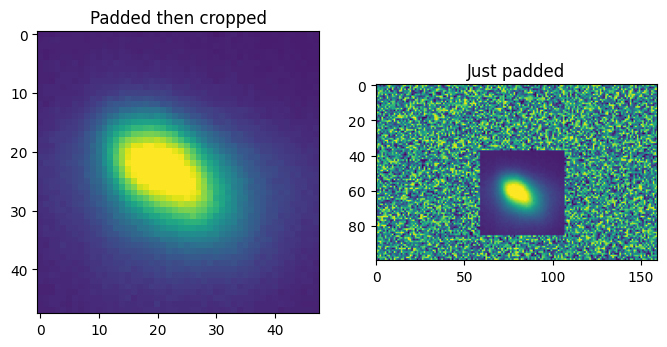

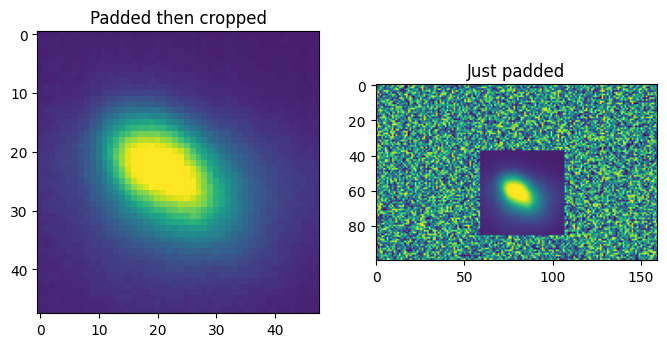

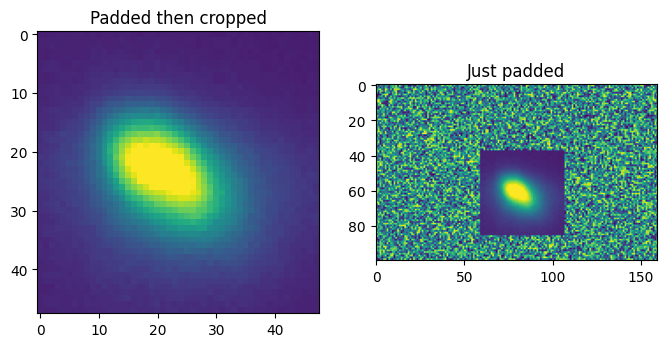

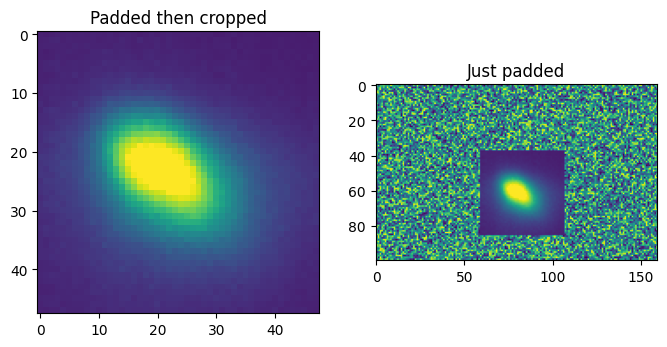

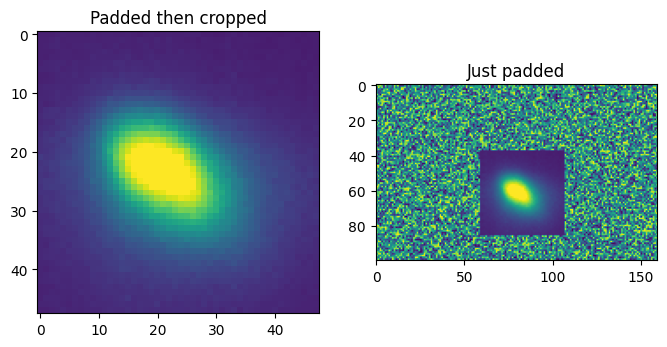

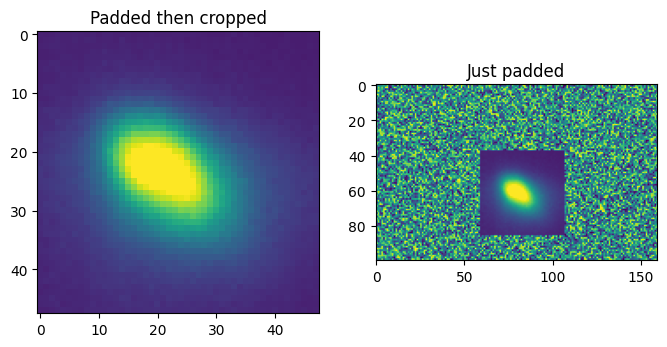

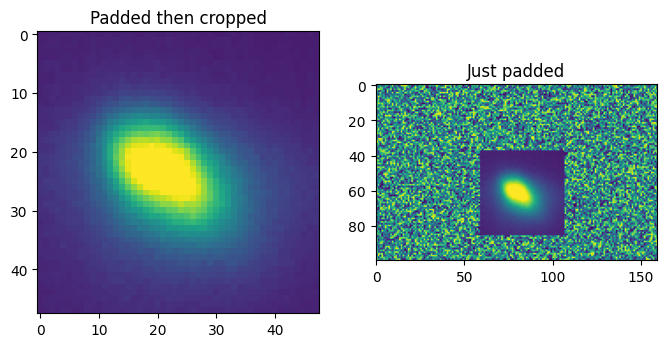

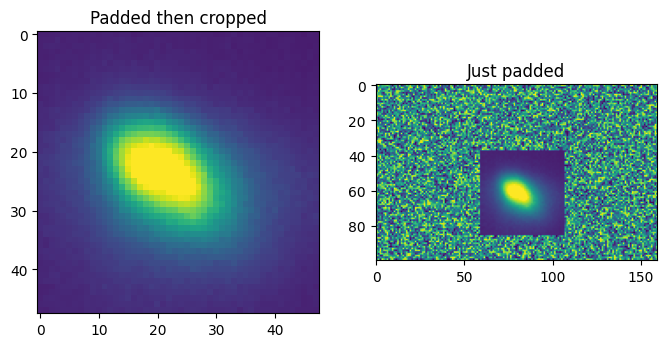

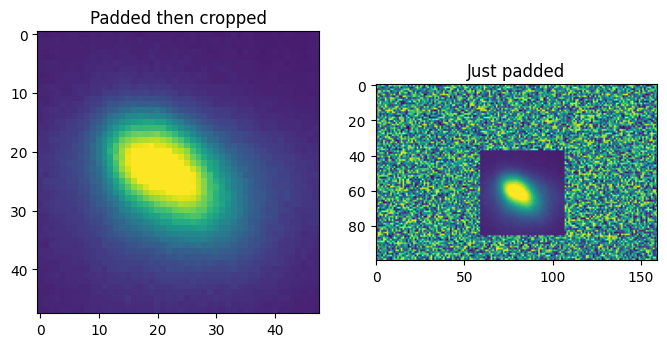

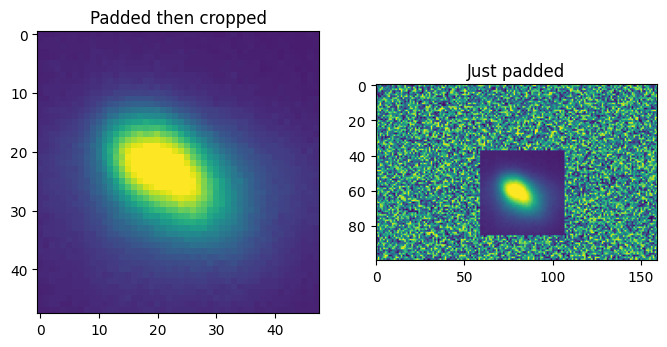

In [23]:
from keras import backend as K
crop_layer = model_cpg.layers[0]
crop_layer_func = K.function(model_cpg.inputs, crop_layer.output)

cropped_padded_normalized_images = crop_layer_func(padded_normalized_images).squeeze()

for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(8, 20))

    axes[0].imshow(cropped_padded_normalized_images[i], vmin=0, vmax=1)
    axes[0].set_title("Padded then cropped")

    axes[1].imshow(padded_normalized_images[i], vmin=0, vmax=1)
    axes[1].set_title("Just padded")

    plt.show(fig)
    plt.close(fig)


These images all look suspiciously similar...

Sanity check:

In [24]:
n_pixels = cropped_padded_normalized_images[9].shape[0] * cropped_padded_normalized_images[9].shape[1]
sum_abs_diff = np.sum(np.abs(cropped_padded_normalized_images[9] - cropped_padded_normalized_images[5]))
avg_diff = sum_abs_diff/n_pixels

print(f"sum_abs_diff = {sum_abs_diff}")
print(f"avg_diff = {avg_diff}")

sum_abs_diff = 15.04705810546875
avg_diff = 0.0065308411916097


# 5. Convert model

In [25]:
# hls_model_cpg.build(csim=False, synth=True, vsynth=True)

In [26]:
hls4ml.report.read_vivado_report(hls_model_cpg.config.config['OutputDir'])

Found 1 solution(s) in model_cpg/1crops_in100x160_out48x48_RF32_ap_fixed_16_2/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Dec 31 12:23:34 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.366|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-------+-------+-------+-------+----------+
    |    Latency    |    Interval   | Pipeline |
    |  min  |  max  |  min  |  max  |   Type   |
    +-------+-------+-------+-------+----------+
    | 

# 6. Save testbench data

In [320]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)


In [321]:
SYSTEMATIC_TESTBENCH = False

############### Input ########################
if SYSTEMATIC_TESTBENCH:
    tb_image = np.array(range(np.prod(IMAGE_SIZE))).reshape((IMAGE_SIZE[0], IMAGE_SIZE[1])).astype(np.float32)
    tb_kpred_model_cpg = model_cpg.predict(tb_image.reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).reshape((5,))
    tb_hpred_model_cpg = hls_model_cpg.predict(np.ascontiguousarray(tb_image))
    STRING_INSERT = "_INDEX"
    VMAX = np.prod(IMAGE_SIZE)
else:
    tb_image = padded_normalized_images[0]
    tb_kpred_model_cpg = kpred_model_cpg[0]
    tb_hpred_model_cpg = hpred_model_cpg[0]
    STRING_INSERT = ""
    VMAX = 1

# float
np.save(os.path.join("testbench/tb_data", f"tb_image{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_float32.npy"), tb_image)

# ap_fixed
with open(os.path.join("testbench/tb_data", f"tb_image{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'w') as f:
    for row in tb_image:
        for val in row:
            f.write(float_to_fixed_point(val, FP_TOTAL, FP_TOTAL - FP_INT - 1))
            f.write('\n')

############### Output #######################

# float
np.save(os.path.join("testbench/tb_data", f"keras_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy"), tb_kpred_model_cpg)
np.save(os.path.join("testbench/tb_data", f"hls_model_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy"), tb_hpred_model_cpg)

# ap_fixed
# tb_hpred_model_cpg_ap_fixed = Fxp(tb_hpred_model_cpg, signed=True, n_word=FP_TOTAL, n_frac=FP_TOTAL-FP_INT).bin()
with open(os.path.join("testbench/tb_data", f"hls_model_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF{REUSE_FACTOR}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'w') as f:
    for g_param in tb_hpred_model_cpg:
        f.write(float_to_fixed_point(g_param.astype(np.float32), FP_TOTAL, FP_TOTAL - FP_INT - 1))
        f.write('\n')

tb_kpred_model_cpg_ap_fixed = Fxp(tb_kpred_model_cpg, signed=True, n_word=FP_TOTAL, n_frac=FP_TOTAL-FP_INT).bin()
with open(os.path.join("testbench/tb_data", f"keras_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'w') as f:
    for g_param in tb_kpred_model_cpg:
        f.write(float_to_fixed_point(g_param.astype(np.float32), FP_TOTAL, FP_TOTAL - FP_INT - 1))
        f.write('\n')

### Check reconstruction accuracy

Text(0.5, 1.0, 'Absolute Difference')

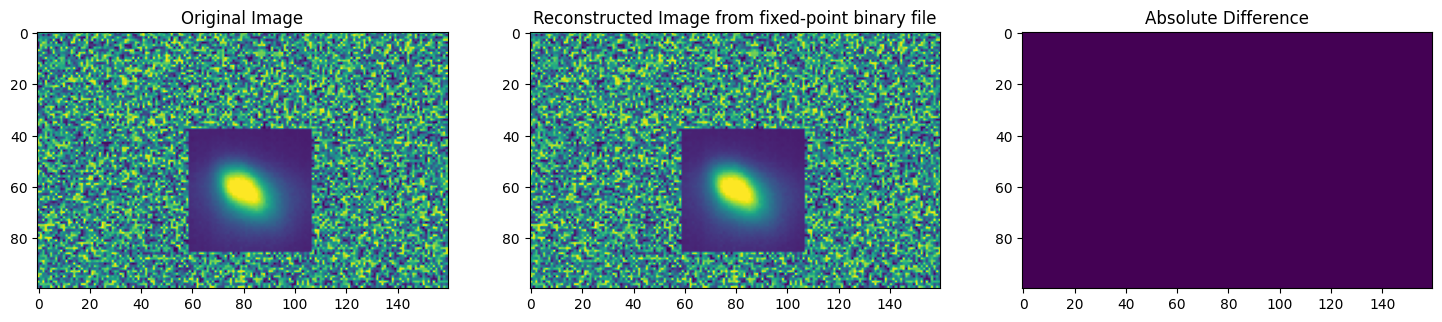

In [324]:
tb_image_ap_fixed_reconstructed = np.zeros(IMAGE_SIZE)#
with open(os.path.join("testbench/tb_data", f"tb_image{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin"), 'r') as f:
    for i, line in enumerate(f):
        row = i//IMAGE_SIZE[1]
        col = i%IMAGE_SIZE[1]
        line = line.replace("\n", "")
        tb_image_ap_fixed_reconstructed[row, col] = fixed_point_to_float(line, FP_TOTAL - FP_INT - 1)


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.imshow(tb_image.squeeze(), vmin=0, vmax=VMAX)
ax1.set_title("Original Image")

ax2.imshow(tb_image_ap_fixed_reconstructed, vmin=0, vmax=VMAX)
ax2.set_title("Reconstructed Image from fixed-point binary file")

ax3.imshow(abs(tb_image.squeeze() - tb_image_ap_fixed_reconstructed), vmin=0, vmax=VMAX)
ax3.set_title("Absolute Difference")

In [326]:
tb_hpred_model_cpg_ap_fixed_reconstructed = np.zeros(tb_hpred_model_cpg.shape, dtype=tb_hpred_model_cpg.dtype)
fpath_tb_hpred_ap_fixed = os.path.join("testbench/tb_data", f"hls_model_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF{REUSE_FACTOR}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")
with open(fpath_tb_hpred_ap_fixed, 'r') as f:
    for i, line in enumerate(f):
        line = line.replace("\n", "")
        val = fixed_point_to_float(line, FP_TOTAL - FP_INT - 1)
        tb_hpred_model_cpg_ap_fixed_reconstructed[i] = val
        
print(tb_hpred_model_cpg)
print(tb_hpred_model_cpg_ap_fixed_reconstructed)

[-0.25494385  0.66534424 -1.0030518   1.4452515   1.2338257 ]
[-0.2548828  0.6652832 -1.0030518  1.4453125  1.2338867]


In [328]:
tb_kpred_model_cpg_ap_fixed_reconstructed = np.zeros(tb_kpred_model_cpg.shape, dtype=tb_kpred_model_cpg.dtype)
fpath_tb_kpred_ap_fixed = os.path.join("testbench/tb_data", f"keras_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")
with open(fpath_tb_kpred_ap_fixed, 'r') as f:
    for i, line in enumerate(f):
        line = line.replace("\n", "")
        val = fixed_point_to_float(line, FP_TOTAL - FP_INT - 1)
        tb_kpred_model_cpg_ap_fixed_reconstructed[i] = val
        
print(tb_kpred_model_cpg)
print(tb_kpred_model_cpg_ap_fixed_reconstructed)

[-0.25800714  0.67496145 -1.0156436   1.4656526   1.2573524 ]
[-0.25805664  0.67492676 -1.015625    1.4656982   1.2573242 ]


### Check consistency with Fxp

In [323]:
x  = -0.94

print(float_to_fixed_point(x, 16, 13))
print(Fxp(x, signed=True, n_word=16, n_frac=13).bin())
print(Fxp(x, signed=True, n_word=16, n_int=2).bin())

1110000111101100
1110000111101100
1110000111101100
